In [10]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
sns.set_style("whitegrid")
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
from op import FleetSizeOptimizer

In [9]:
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date
        try:
            with open(f'../output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
        
            with open(f'../output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleet_i = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))

            if fleet_i == 7:
                df  = pd.read_csv(f'../input/demand_variation/passenger_arrival/alpha_7_demand_500/{month}_{day}.csv')
                df.to_csv(f'for_emin/passenger_arrival_demand_500_{month}_{day}.csv', index=False)
        
        except FileNotFoundError:
            continue

fleetsize_07 = np.array(fleetsize_07)




In [17]:
os.listdir()

['input',
 'example',
 'wind_variation_result.sqlite',
 '.gitignore',
 'output',
 'archive',
 '2_run_time_varying_wind_spill.py',
 'model',
 '1_run_time_varying_wind.py',
 'wind_data_processor_icrat.ipynb',
 'docs',
 '.git',
 'DemandUncertainty',
 '.gitattributes',
 'README.md']

In [18]:


model = FleetSizeOptimizer(flight_time=np.array([[0, 10], [10, 0]]), energy_consumption=np.array([[0, 10], [10, 0]]), 
                            schedule=f'demand_variation/schedule/alpha_7_demand_500_/{month}_{day}.csv')
# model.parse_result(f'demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_op_results.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'input/demand_variation/schedule/alpha_7_demand_500_/12_31.csv'

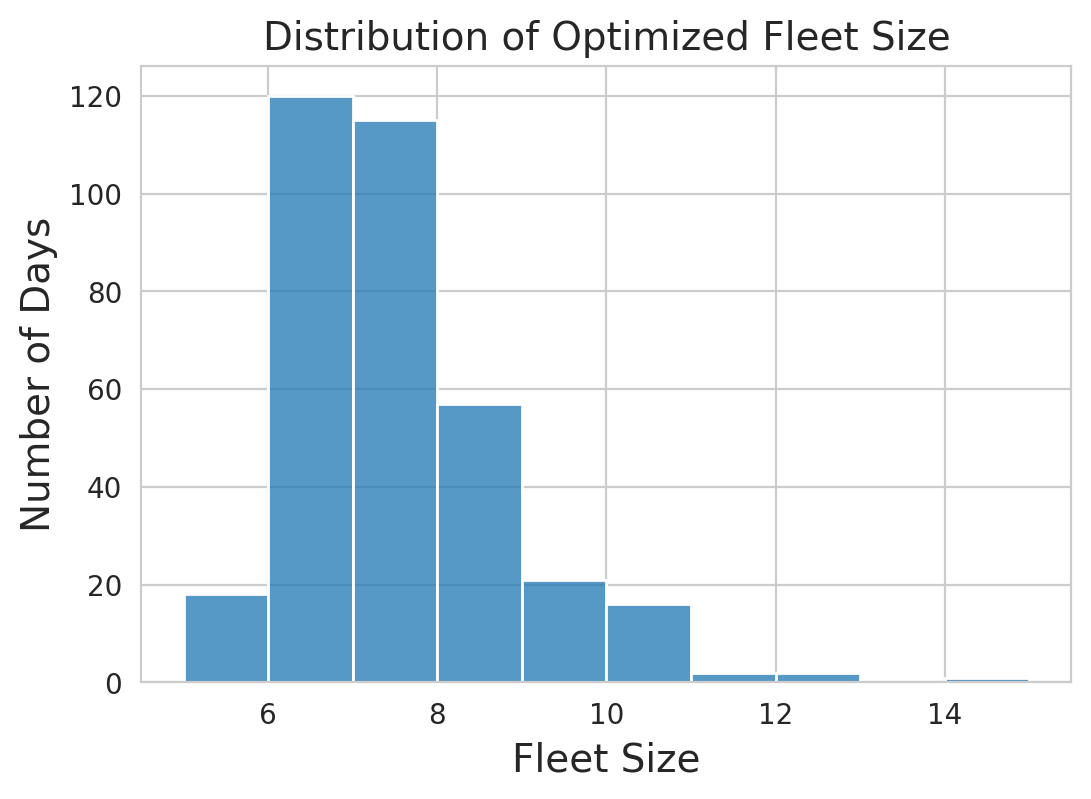

In [8]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(fleetsize_07, binwidth=1, ax=ax)
ax.set(xlabel='Fleet Size', ylabel='Number of Days', title='Distribution of Optimized Fleet Size');

In [33]:
input_fleet_size = 12
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        with open(f'../output/demand_variation/fleet_op_result/alpha_7/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
            if fleetsize > input_fleet_size:
                pass

In [17]:
result = pd.DataFrame({'val':np.concatenate([fleetsize_06, fleetsize_07]), 'alpha':np.concatenate([np.repeat(0.6, len(fleetsize_06)), np.repeat(0.7, len(fleetsize_07))])})

Text(0.5, 1.0, 'Distribution of Fleet Size for 365 Autorregressive Samples')

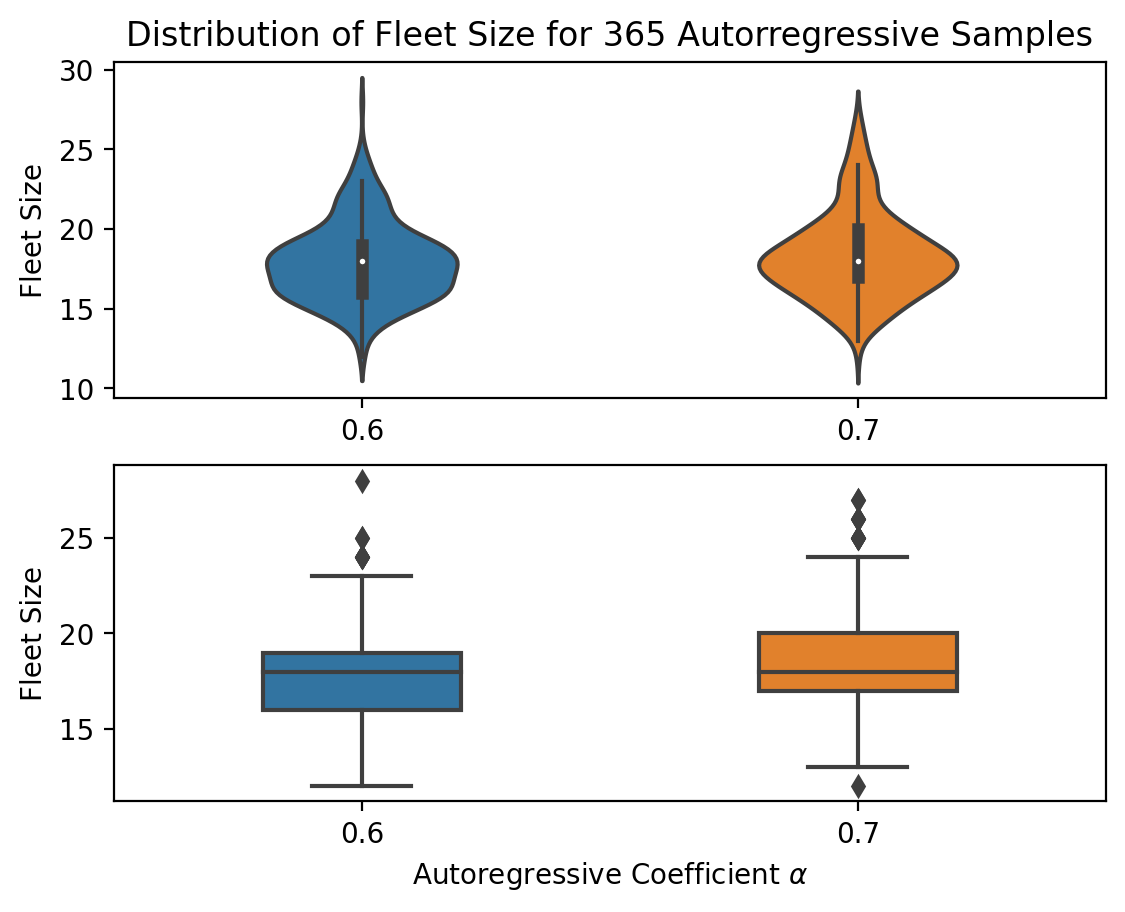

In [38]:
fig, ax = plt.subplots(nrows=2, dpi=200)
sns.violinplot(data=result, x='alpha', y='val',width=0.4, ax=ax[0])
sns.boxplot(data=result, x='alpha', y='val',width=0.4, ax=ax[1])
ax[0].set(xlabel='')
ax[1].set(xlabel='Autoregressive Coefficient $\\alpha$')
for i in range(2):
    ax[i].set(ylabel='Fleet Size')
ax[0].set_title('Distribution of Fleet Size for 365 Autorregressive Samples')


In [98]:
path = '../output/demand_variation/schedule/'

flight_demand_06 = []
flight_demand_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        flight_demand_06.append(pd.read_csv(path+f'{month}_{day}_6.csv').shape[0])
        flight_demand_07.append(pd.read_csv(path+f'{month}_{day}_7.csv').shape[0])

flight_demand_06 = np.array(flight_demand_06)
flight_demand_07 = np.array(flight_demand_07)


# Start here

In [18]:
import os
# os.chdir('../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import model.queueing_model
importlib.reload(model.queueing_model)
from model.queueing_model import system, one_vertiport_system
from tqdm import tqdm
import re

In [49]:
files = os.listdir('output/demand_variation/spill_op_result/alpha_7')
all_files = []
for file in files:
    if file.endswith('_total_spill.txt'):
        all_files.append(file)
file_names = np.empty(shape=(0, 3))
for i in all_files:
    file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

In [21]:
upper_bound = np.zeros(4)
lower_bound = np.zeros(4)
for month in tqdm(range(1, 13)):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid dates
        else:
            with open(f'output/demand_variation/fleet_op_result/alpha_7/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
            
            for i in range(12, 16):
                if fleetsize > i:
                    s = system(i, f'output/demand_variation/schedule/alpha_7/num_pax_{month}_{day}.csv', f'output/demand_variation/schedule/alpha_7/{month}_{day}.csv')
                    upper_bound[i-12] += s.logger(True)

                    s2 = one_vertiport_system(i, f'output/demand_variation/schedule/alpha_7/num_pax_{month}_{day}.csv', f'output/demand_variation/schedule/alpha_7/{month}_{day}.csv')
                    lower_bound[i-12] += s2.logger(True)
    

100%|██████████| 12/12 [02:12<00:00, 11.05s/it]


In [28]:
x = np.arange(10)+15
y = np.zeros(10, dtype=int)

In [60]:
for i in range(file_names.shape[0]):
    with open('output/demand_variation/spill_op_result/alpha_7/'+all_files[i], 'r') as f:
        spill = float(f.readline().split(': ')[1])
    y[int(file_names[i,2])-15] += spill

In [61]:
all_files

['6_6_18_total_spill.txt',
 '8_1_15_total_spill.txt',
 '4_27_16_total_spill.txt',
 '11_15_15_total_spill.txt',
 '12_2_15_total_spill.txt',
 '1_11_15_total_spill.txt',
 '11_26_20_total_spill.txt',
 '5_30_16_total_spill.txt',
 '8_29_18_total_spill.txt',
 '1_4_16_total_spill.txt',
 '3_22_15_total_spill.txt',
 '7_17_15_total_spill.txt',
 '4_2_18_total_spill.txt',
 '8_23_21_total_spill.txt',
 '6_14_16_total_spill.txt',
 '9_13_17_total_spill.txt',
 '10_10_18_total_spill.txt',
 '10_12_15_total_spill.txt',
 '8_8_16_total_spill.txt',
 '11_11_16_total_spill.txt',
 '8_22_16_total_spill.txt',
 '10_4_18_total_spill.txt',
 '9_13_18_total_spill.txt',
 '5_5_15_total_spill.txt',
 '9_11_15_total_spill.txt',
 '6_14_19_total_spill.txt',
 '5_8_15_total_spill.txt',
 '4_2_17_total_spill.txt',
 '11_21_16_total_spill.txt',
 '8_22_19_total_spill.txt',
 '10_4_17_total_spill.txt',
 '8_8_19_total_spill.txt',
 '11_3_15_total_spill.txt',
 '10_10_17_total_spill.txt',
 '7_1_15_total_spill.txt',
 '8_28_20_total_spill.t

In [58]:
spill

132.0

In [65]:
out = [[] for i in range(10)]
for i in range(file_names.shape[0]):
    with open('output/demand_variation/spill_op_result/alpha_7/'+all_files[i], 'r') as f:
        spill = float(f.readline().split(': ')[1])
    out[int(file_names[i,2])-15].append(spill)

In [66]:
out

[[132.0,
  108.0,
  28.0,
  4.0,
  8.0,
  140.0,
  59.0,
  96.0,
  76.0,
  4.0,
  8.0,
  4.0,
  147.0,
  56.0,
  0.0,
  59.0,
  12.0,
  32.0,
  116.0,
  0.0,
  171.0,
  17.0,
  36.0,
  88.0,
  4.0,
  103.0,
  4.0,
  112.0,
  75.0,
  4.0,
  104.0,
  32.0,
  88.0,
  8.0,
  8.0,
  136.0,
  0.0,
  119.0,
  4.0,
  28.0,
  72.0,
  4.0,
  112.0,
  16.0,
  12.0,
  6.0,
  115.0,
  96.0,
  25.0,
  4.0,
  12.0,
  4.0,
  0.0,
  64.0,
  4.0,
  15.0,
  12.0,
  144.0,
  0.0,
  24.0,
  140.0,
  8.0,
  51.0,
  12.0,
  148.0,
  136.0,
  40.0,
  4.0,
  8.0,
  67.0,
  0.0,
  61.0,
  112.0,
  4.0,
  20.0,
  0.0,
  36.0,
  4.0,
  60.0,
  116.0,
  4.0,
  96.0,
  16.0,
  8.0,
  184.0,
  4.0,
  140.0,
  4.0,
  4.0,
  8.0,
  112.0,
  8.0,
  0.0,
  112.0,
  0.0,
  4.0,
  0.0,
  8.0,
  4.0,
  0.0,
  8.0,
  4.0,
  102.0,
  4.0,
  45.0,
  4.0,
  0.0,
  0.0,
  8.0,
  44.0,
  0.0,
  171.0,
  4.0,
  152.0,
  4.0,
  12.0,
  64.0,
  108.0,
  124.0,
  59.0,
  149.0,
  8.0,
  28.0,
  4.0,
  16.0,
  4.0,
  4.0,
  96.0],
 [

<Axes: ylabel='Count'>

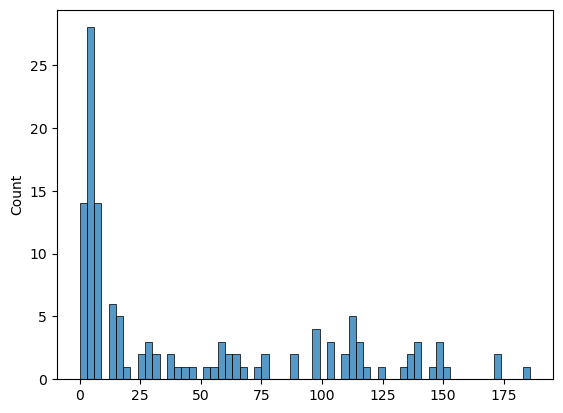

In [74]:
import seaborn as sns
sns.histplot(out[0], binwidth=3)

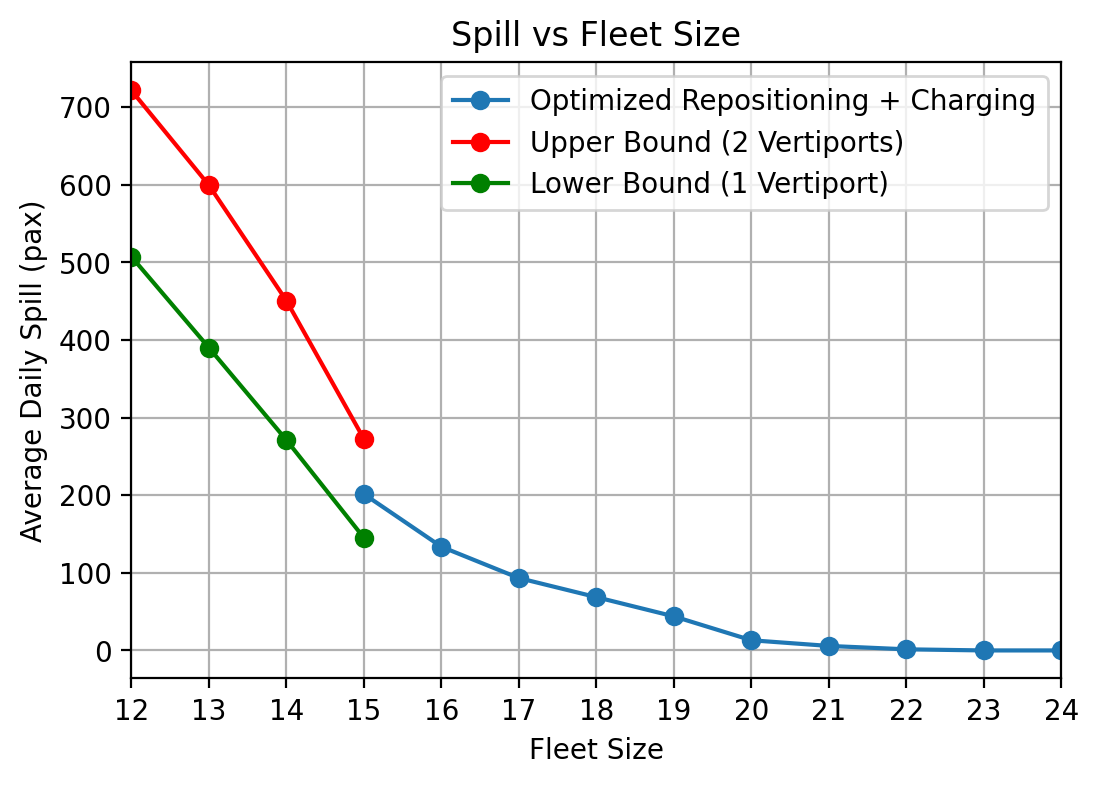

In [62]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(x, y/365, marker='o',
       label='Optimized Repositioning + Charging')
ax.plot(np.arange(12, 16), upper_bound/365, marker='o', color='red', 
       label='Upper Bound (2 Vertiports)')
ax.plot(np.arange(12, 16), lower_bound/365, marker='o', color='green', 
       label='Lower Bound (1 Vertiport)')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size',
       xticks=np.arange(12, 25, 1),
       xlim=(12, 24))
plt.grid()
plt.legend();

In [ ]:
# beta * F to give a cost of acquiring a new aircraft
# full process documented
# seat capacity of a flght / seats of the entire year * (365*1500)

## Get a new demand profile

In [1]:
from UAM_Schedule import UAM_Schedule

In [2]:
sche = UAM_Schedule('LAX_ind.csv', 'T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax = sche.get_one_day(7, 7)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)
import numpy as np

lax_dtla_sche = schedule[schedule['od'] == 'LAX_DTLA']
dtla_lax_sche = schedule[schedule['od'] == 'DTLA_LAX']

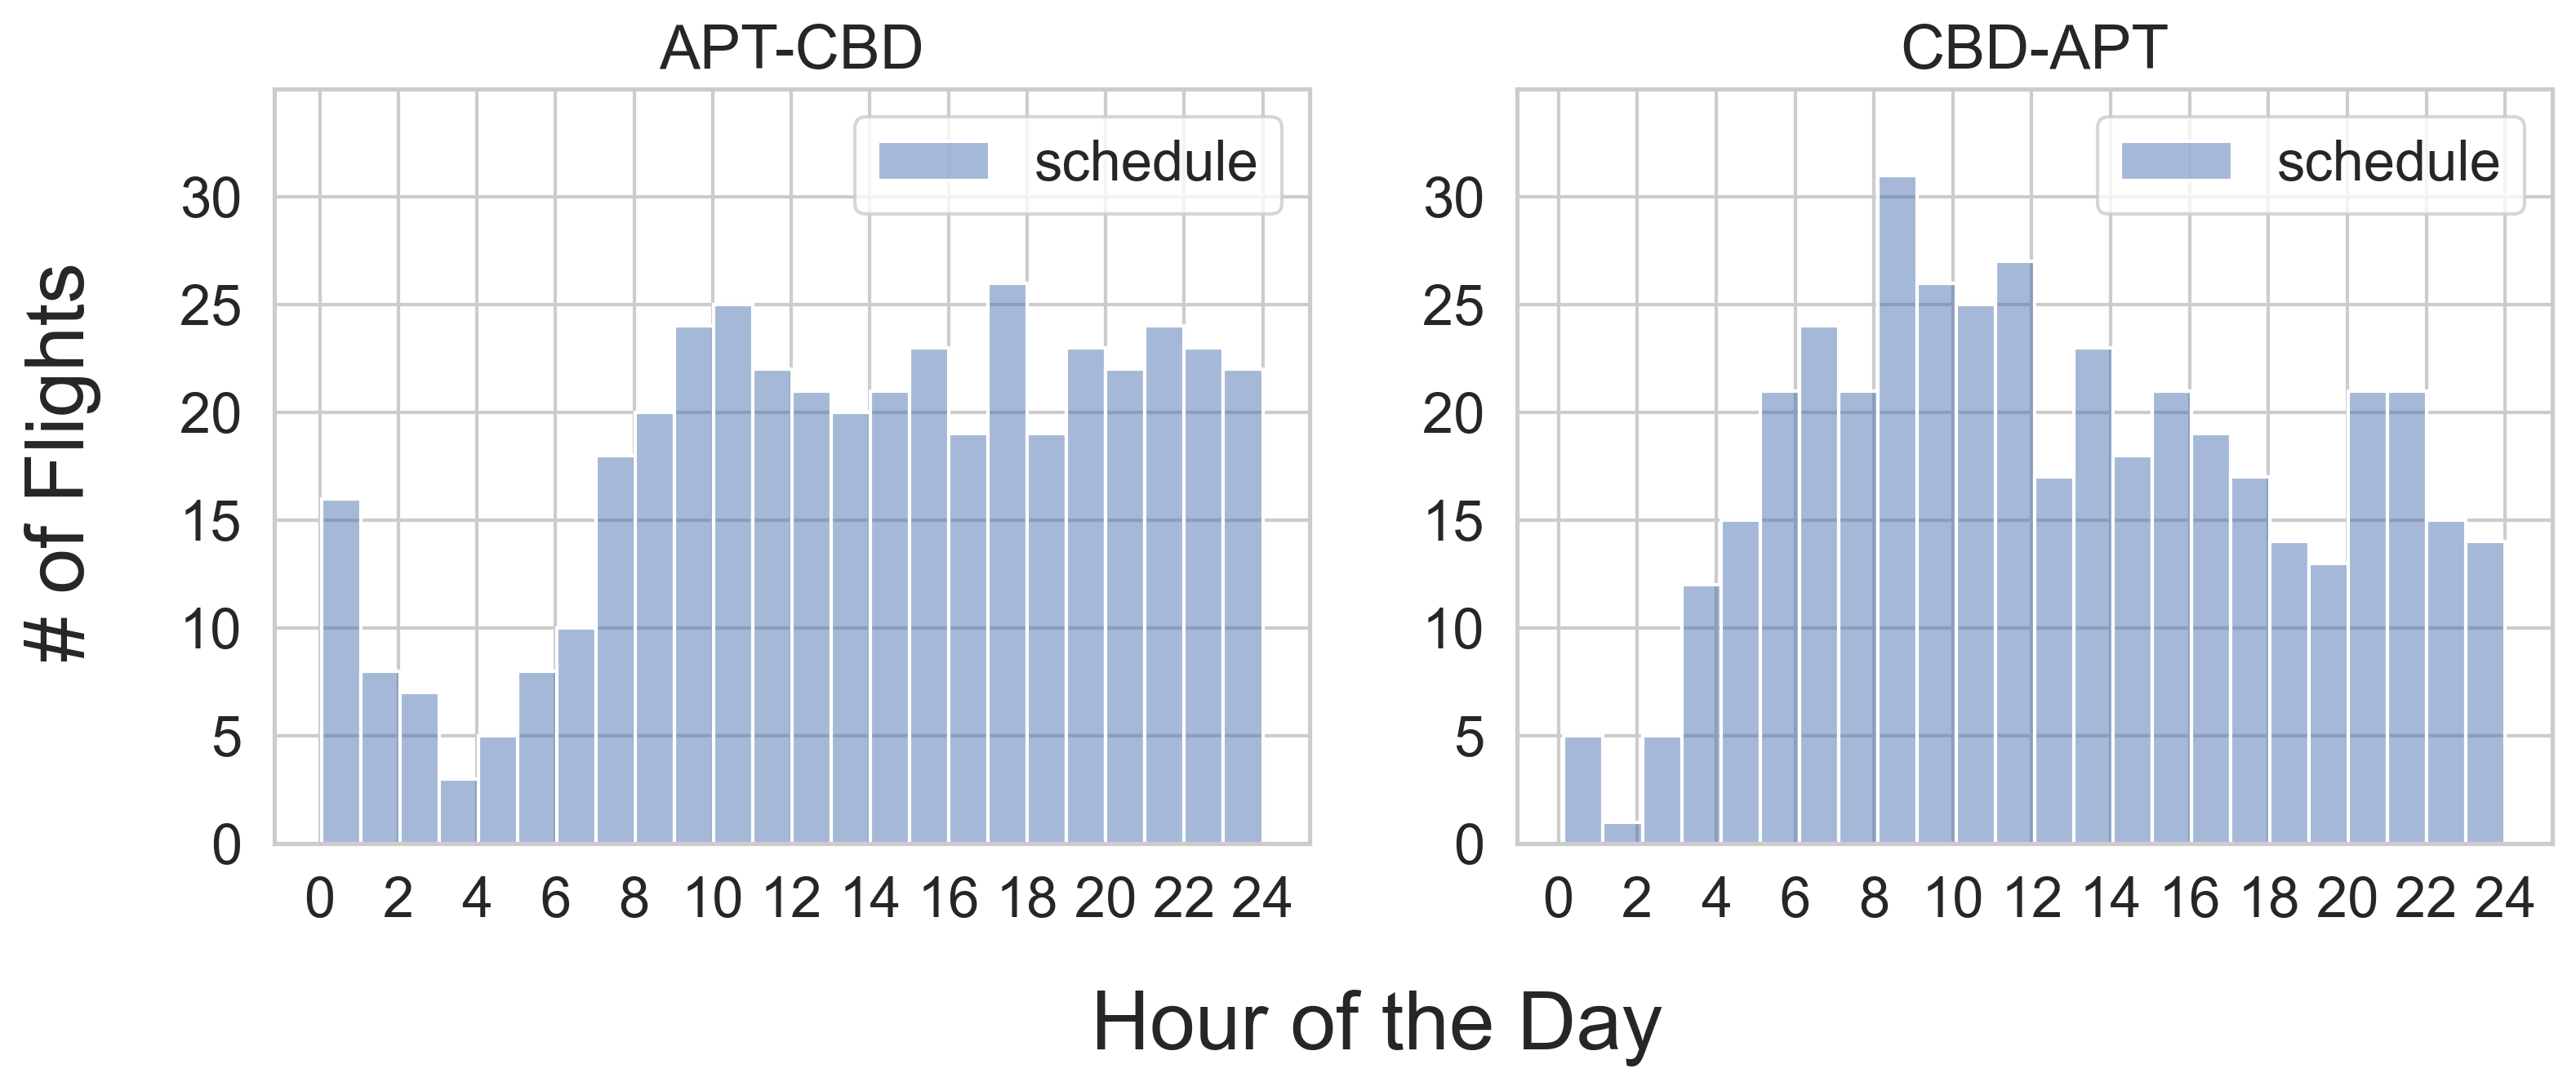

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(lax_dtla_sche, bins=24, ax=ax[0], label='LAX-DTLA')
sns.histplot(dtla_lax_sche, bins=24, ax=ax[1], label='DTLA-LAX', color='orange')

for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
              xticks=np.arange(0,1560,120), 
              xticklabels=np.arange(0,26,2),
              yticks=np.arange(0,32,5),
              ylim=(0,35))

ax[0].set(title='APT-CBD')
ax[1].set(title='CBD-APT')
fig.text(0.5, -0.1, 'Hour of the Day', ha='center', fontsize=24)
# fig.text(0.5, 1, 'Hourly Scheduled Departures at Vertiports \n (5min threshold)', ha='center', fontsize=24)
fig.text(0.04, 0.5, '# of Flights', va='center', rotation='vertical', fontsize=24)
plt.gcf().set_dpi(300)

In [7]:
schedule.to_csv('../input/ICRAT/schedule_1500pax_5min_0125.csv', index=False)
num_pax.to_csv('../input/ICRAT/num_pax_1500pax_5min_0125.csv', index=False)